# 레이블 불균형(예측 성능에 문제가 발생하므로 데이터의 전처리 필요)
- 건수 적은 레이블 데이터: 다양한 유형을 학습하지 못함
- 건수 많은 레이블 데이터: 일방적으로 치우친 학습

## 언더 샘플링(Undersampling): 많은 데이터셋을 적은 데이터셋으로 수정
    - 다수 클래스 데이터 수 감소
    - 데이터 제거로 인한 정보 손실
    
        1. Random Undersampling
            - 무작위로 제거, 할 때마다 결과가 달라짐
            
        2. Tomek Links
            - 다수 클래스 데이터 x, 소수 클래스 데이터 y
            - x와 y 거리보다 가가운 데이터가 없으면 Tomek Link
            - Tomek Link들을 찾은 후 다수 클래스의 데이터 삭제

        3. CNN(Condensed Nearest Neighbor)
            - 소수 클래스 데이터 무작위 한 개 + 다수 클래스 데이터 무작위 한 개
            - 1 - NN로 분류
            - 다수 클랫로 분류된 데이터 삭제
        
        4. OSS(One-Side Selection)
            - Tomek Links + CNN

## 오버 샘플링(Oversampling): 적은 데이터셋을 많은 데이터셋으로 증식하여 충분한 데이터 확보

    1. Resampling
        - 소수 클래스 데이터 복제 => 과적합(Overfitting) 가능성
    
    2. SMOTE(Synthetic Minority Over-sampling Technique)
        - 소수 클래스 데이터에서 임의로 하나 선택 (p1)
        - 선택된 데이터에서 가장 가까운 k개 데이터(k > 1)
        - k개 데이터 중 임으로 하나 선택 (p2)
        - p1과 p2를 잇는 직선 상의 임의의 위치에 데이터 생성
            - 이를 나머지 소수 클래스 데이터에 대해 반복한다

    3. Borderline-SMOTE
        - 클래스 간의 경계 부분에서만 SMOTE

    4. ADASYN(Adaptive Synthetic sampling approach)
        - 위치에 다라 샘플링 개수를 다르게

# 신용 카드 사기 검출

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

df = pd.read_csv(r'D:\git_space\MSN\Machine-Learning\data\creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

def get_train_test_dataset(df):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df)
print(y_train.value_counts() / y_train.shape[0] * 100)
print(y_test.value_counts() / y_test.shape[0] * 100)

0    99.827451
1     0.172549
Name: Class, dtype: float64
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_prob=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print(confusion)
    print('accuracy: ', accuracy)
    print('precision: ', precision)
    print('recall:' , recall)
    print('f1: ', f1)
    print('roc_auc: ', roc_auc)

In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
pred_prob = lr.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_prob)

[[85276    19]
 [   60    88]]
accuracy:  0.9990754069964772
precision:  0.822429906542056
recall: 0.5945945945945946
f1:  0.6901960784313725
roc_auc:  0.7971859191391404


In [14]:
def get_model_train_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:,1]
    get_clf_eval(y_test, pred, pred_prob)

In [15]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

[[85287     8]
 [   33   115]]
accuracy:  0.9995201479348805
precision:  0.9349593495934959
recall: 0.777027027027027
f1:  0.8487084870848709
roc_auc:  0.8884666174469211


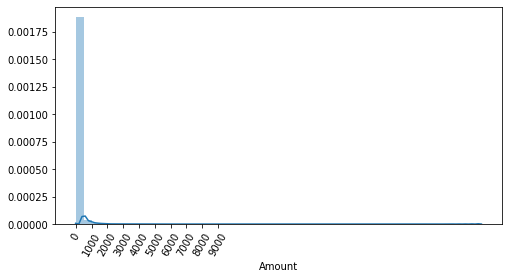

In [16]:
import seaborn as sns 

plt.figure(figsize=(8,4))
plt.xticks(range(0, 10000, 1000), rotation=60)
sns.distplot(df['Amount'])

In [17]:
# Amount를 정규분포로 변환
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(df)
lr = LogisticRegression()
get_model_train_eval(lr, X_train, X_test, y_train, y_test)
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

[[85285    10]
 [   52    96]]
accuracy:  0.9992743700478681
precision:  0.9056603773584906
recall: 0.6486486486486487
f1:  0.7559055118110237
roc_auc:  0.8242657042410838
[[85277    18]
 [  104    44]]
accuracy:  0.9985721475135471
precision:  0.7096774193548387
recall: 0.2972972972972973
f1:  0.41904761904761906
roc_auc:  0.6485431324988158


### StandardScaler를 사용하였는데 Score가 다소 이상하다. Log 변환을 해보자

In [19]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Acount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(df)
get_model_train_eval(lr, X_train, X_test, y_train, y_test)
get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

[[85284    11]
 [   54    94]]
accuracy:  0.9992392589211521
precision:  0.8952380952380953
recall: 0.6351351351351351
f1:  0.7430830039525692
roc_auc:  0.817503085476003
[[85239    56]
 [   69    79]]
accuracy:  0.998537036386831
precision:  0.5851851851851851
recall: 0.5337837837837838
f1:  0.558303886925795
roc_auc:  0.766563619425745


### 그래도 값이 썩 좋지는 못하다. 이상치(Outlier)가 있는지 확인해 보자

(31, 0)

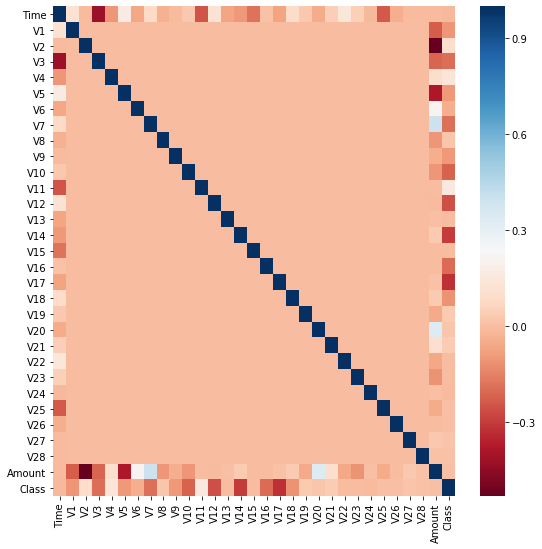

In [25]:
import seaborn as sns 

plt.figure(figsize=(9,9))
corr = df.corr()
ax = sns.heatmap(corr, cmap='RdBu')
ax.set_ylim(31, 0)

### V14를 Outlier라 판단하고 이를 제거한다

In [28]:
def get_outlier(df, column, weight=1.5):
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25) # 1분위 수 (Q1)
    quantile_75 = np.percentile(fraud.values, 75) # 3분위 수 (Q3)
    iqr = quantile_75 - quantile_25 # Inter Quantile Range
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index # Outlier: (Q1-iqr*1.5) ~ (Q3+iqr*1.5) 밖에 있는 자료  
    return outlier_index

outlier_index = get_outlier(df, 'V14', 1.5)
print(outlier_index)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [29]:
def get_preprocessed_df(df):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Acount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df_copy, 'V14', 1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(df)
get_model_train_eval(lr, X_train, X_test, y_train, y_test)
get_model_train_eval(lgbm, X_train, X_test, y_train, y_test)

[[85284    11]
 [   59    87]]
accuracy:  0.9991807211994241
precision:  0.8877551020408163
recall: 0.5958904109589042
f1:  0.7131147540983606
roc_auc:  0.7978807233878874
[[85193   102]
 [   84    62]]
accuracy:  0.9978230591870414
precision:  0.3780487804878049
recall: 0.4246575342465753
f1:  0.39999999999999997
roc_auc:  0.7117308422742343


### Outlier를 제거했는데도 Score가 좋지 못하다. 상대적으로 작은 데이터셋에 SMOTE를 적용하자(사기 건 수가 훨씬 적으므로 이에 SMOTE 적용)

In [31]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

(199362, 29) (199362,)
(398040, 29) (398040,)
1    199020
0    199020
dtype: int64


In [32]:
lr = LogisticRegression()
get_model_train_eval(lr, X_train_over, X_test, y_train_over, y_test)

[[83242  2053]
 [   13   133]]
accuracy:  0.9758195714001475
precision:  0.060841720036596526
recall: 0.910958904109589
f1:  0.11406518010291597
roc_auc:  0.943444748965516


### precision 과 f1의 값이 왜저럴까

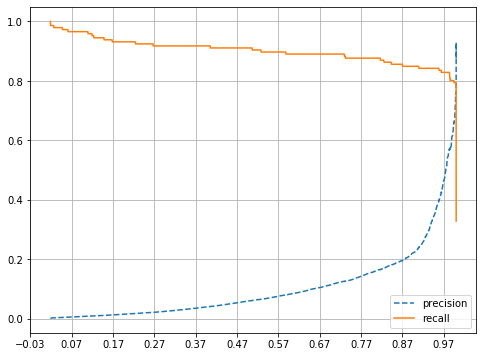

In [34]:
from sklearn.metrics import precision_recall_curve

def precision_recall_curve_plot(y_test, pred_prob):
    precision, recalls, thresholds = precision_recall_curve(y_test, pred_prob)
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.legend()
    plt.grid()
    plt.show()

precision_recall_curve_plot(y_test, lr.predict_proba(X_test)[:,1])

In [35]:
lgbm = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm, X_train_over, X_test, y_train_over, y_test)

[[85281    14]
 [   26   120]]
accuracy:  0.9995318406853853
precision:  0.8955223880597015
recall: 0.821917808219178
f1:  0.8571428571428571
roc_auc:  0.9108768359930522


### LightGBM으로 돌려보니 Score가 좋게 나온다!